# ATMS 523 - Module 8

This notebook inspects uses the `calgary_hourly.csv` dataset (hourly 1974-2024 weather station data) for detection and analysis of Chinook events.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy import stats
from scipy.stats import kendalltau

import os

### 1. Loading and Cleaning the Data

Loading the dataset and identifying the columns relevant to Chinook analysis: Temperature (`temp`), Pressure (`pressure`), Relative Humidity (`rel_hum`), and Wind (`wind_dir`, `wind_spd`).

In [14]:
# Define file path assuming standard directory structure
# I ran into issues with some datapoints being duplicated for two months in 2012, but this csv has the duplicate days removed.
df_initial = pd.read_csv('Data/calgary_hourly_nodup.csv')

C:\Users\macdonaldc\AppData\Local\Temp\ipykernel_30740\3734621788.py:3: DtypeWarning: Columns (21,23,26,27,29,31,33,35,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df_initial = pd.read_csv('Data/calgary_hourly_nodup.csv')


In [15]:
# Filter for relevant columns
relevant_cols = ['temp', 'pressure', 'rel_hum', 'wind_dir', 'wind_spd', 'date', 'time']

df_subset = df_initial[relevant_cols]
df_subset.head()

,temp,pressure,rel_hum,wind_dir,wind_spd,date,time
0,-9.4,89.85,72.0,33.0,42.0,1974-01-01,1974-01-01T00:00:00Z
1,-8.3,89.87,69.0,33.0,51.0,1974-01-01,1974-01-01T01:00:00Z
2,-8.9,89.85,72.0,32.0,53.0,1974-01-01,1974-01-01T02:00:00Z
3,-8.9,89.89,73.0,33.0,39.0,1974-01-01,1974-01-01T03:00:00Z
4,-8.3,89.86,72.0,33.0,42.0,1974-01-01,1974-01-01T04:00:00Z


Identifying how many missing entries there are for the important variables.

In [16]:
print("Missing:")
print(df_subset.isna().sum())

Missing:
temp          248
pressure      234
rel_hum       275
wind_dir    32159
wind_spd      242
date            0
time            0
dtype: int64


Check for extremes any other concerning values (e.g., negative wind speed, impossible temperatures).

In [17]:
numerical_cols = ['temp', 'pressure', 'rel_hum', 'wind_dir', 'wind_spd']
numerical_cols = [c for c in numerical_cols if c in df_subset.columns]

print("Summary statistics:")
print(df_subset[numerical_cols].describe().round(2))

Summary statistics:
            temp   pressure    rel_hum  wind_dir   wind_spd
count  446824.00  446838.00  446797.00  414913.0  446830.00
mean        4.72      88.90      61.17      21.6      14.32
std        11.45       0.71      20.35      10.0       9.82
min       -38.60      84.67       8.00       0.0       0.00
25%        -2.20      88.45      45.00      15.0       7.00
50%         5.60      88.94      63.00      21.0      13.00
75%        12.90      89.38      78.00      31.0      20.00
max        36.40      91.71     100.00      36.0      93.00


Looks good, temps, pressures, and humidities in a normal range. Wind speeds are in deg 10!

Checking the impact of dropping all rows with missing data. Looking at the total retention rate and retention by decade to make sure the NaNs aren't clusted in a certain decade.

In [18]:
# Calculate total retention
total_rows = len(df_subset)
df_cleaned = df_subset.dropna()
retained_rows = len(df_cleaned)
retention_rate = (retained_rows / total_rows) * 100

print(f"Total Rows: {total_rows}")
print(f"Rows after dropping NaNs: {retained_rows}")
print(f"Percent of Rows Retained: {retention_rate:.2f}%")

Total Rows: 447072
Rows after dropping NaNs: 414845
Percent of Rows Retained: 92.79%


In [19]:
# Calculate retention by decade
# Making sure data is datetime.
df_analysis = df_subset.copy()
df_analysis['date'] = pd.to_datetime(df_analysis['date'])
df_analysis['decade'] = (df_analysis['date'].dt.year // 10) * 10

# Calculate counts by decade
total_by_decade = df_analysis.groupby('decade').size()
dropped_by_decade = df_analysis.dropna().groupby('decade').size()

# Combine and calculate percentage
retention_df = pd.DataFrame({'Total': total_by_decade, 'Retained': dropped_by_decade})
retention_df['Percentage'] = (retention_df['Retained'] / retention_df['Total']) * 100

print("Retention by Decade:")
print(retention_df.round(2))

Retention by Decade:
        Total  Retained  Percentage
decade                             
1970    52584     47184       89.73
1980    87672     79723       90.93
1990    87648     80331       91.65
2000    87672     82700       94.33
2010    87648     82663       94.31
2020    43848     42244       96.34


Not too bad. Some data missing in the 1970s and 1980s relative to other decades, but not enough to throw off the trend analysis by too much.

Dropping the rows with missing values and save the cleaned dataset to a new CSV file.

In [20]:
df_cleaned.to_csv('Data/calgary_hourly_cleaned.csv')

### 2. Preparing the dataset and feature engineering

Creating the engineered features and selecting just winter months. Getting the data ready for the SKLean models.

In [21]:
# Importing the data
df = pd.read_csv('Data/calgary_hourly_cleaned.csv')

# Creating DateTime Index
df['datetime'] = pd.to_datetime(df['time'])
df = df.set_index('datetime').sort_index()
print(df.shape)

(414845, 8)


Next, creating the engineered features. This includes temp, pressure, and humidity delta at a 6h lag. 

This also includes wind components. Using the sin and cos of each wind direction rather than 0-360. I think this will help during PCA.

In [22]:
# 6-hour Deltas for temperature and pressure
df['temp_delta_6h'] = df['temp'].diff(6)
df['pressure_delta_6h'] = df['pressure'].diff(6)
df['humidity_delta_6h'] = df['rel_hum'].diff(6)

# Wind Components
# wind_dir is 0-36 (tens of degrees), so multiplying by 10 first
# For Westerly winds: sin(270) = -1, cos(270) = 0
df['wind_rad'] = np.deg2rad(df['wind_dir'] * 10)
# Negative = Westerly component
df['wind_sin'] = np.sin(df['wind_rad'])  
# Positive = Northerly component
df['wind_cos'] = np.cos(df['wind_rad'])  

# Drop NaNs created by diff operations (noticed this (understandably) introduced some NAs around the edges of the dataset)
df_analysis = df.dropna().copy()

Making a new df with just the winter months now.

In [23]:
# Winter months (Chinooks are a winter event, so need to check the other months)
CHINOOK_MONTHS = [10, 11, 12, 1, 2, 3]  # Oct-Mar

df_analysis['month'] = df_analysis.index.month
df_winter = df_analysis[df_analysis['month'].isin(CHINOOK_MONTHS)].copy()


### 3. Identifying Chinooks
Using isolation forest followed by k-means clustering to identify chinooks.

Beginning by setting the parameters for the models here so I can experiment with them later.

In [24]:
# Expected proportion of anomalies (2% = rare events)
CONTAMINATION = 0.02
# Minimum hours to count as a "Chinook day" (don't just a single hour to tip the scale, want to make sure the signal is strong)
CHINOOK_MIN_HOURS_PER_DAY = 3  

In [25]:
# The list of key features for anomaly detection
features_to_scale = [
    'temp_delta_6h',      # Rapid warming
    'pressure_delta_6h',  # Pressure changes
    'humidity_delta_6h',  # Humidity drops
    'rel_hum',            # Absolute humidity (Chinooks are dry)
    'wind_spd',           # Wind speed
    'wind_sin',           # E-W wind component (negative = west)
    'wind_cos'            # N-S wind component (positive = north)
]

scaler = StandardScaler()
# Making the X Data from the list of features
X_scaled = scaler.fit_transform(df_winter[features_to_scale])

# Setting up the isolation forest model
iso_forest = IsolationForest(
    n_estimators=200,
    contamination=CONTAMINATION,
    random_state=42,
    n_jobs=-1
)

# Fit and predict: -1 = anomaly (potential Chinook), 1 = normal
# Drawing from the documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html 
# and https://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html
df_winter['anomaly'] = iso_forest.fit_predict(X_scaled)
df_winter['anomaly_score'] = iso_forest.decision_function(X_scaled)

# Count of the anomalies
n_anomalies = (df_winter['anomaly'] == -1).sum()
print(f"Anomalies: {n_anomalies}")
# Should be ~2%
print(f"Percentage Anomalies: {n_anomalies/len(df_winter) *100}")


Anomalies: 4107
Percentage Anomalies: 2.000263000248389


Printing the results of the anomalies and the non-anomalies for comparison

In [26]:
anomalies = df_winter[df_winter['anomaly'] == -1].copy()
normal = df_winter[df_winter['anomaly'] == 1].copy()

# Circular mean function for wind direction 
# (I got weird results doing a regular avg and learned you can't just take the avg rads for angles) - thanks stackexchange!
def circular_mean(angles_deg):
    angles_rad = np.deg2rad(angles_deg)
    mean_sin = np.mean(np.sin(angles_rad))
    mean_cos = np.mean(np.cos(angles_rad))
    mean_angle = np.rad2deg(np.arctan2(mean_sin, mean_cos))
    return mean_angle % 360

# Add wind direction in degrees
anomalies['wind_dir_deg'] = anomalies['wind_dir'] * 10
normal['wind_dir_deg'] = normal['wind_dir'] * 10

comparison_features = ['temp_delta_6h', 'pressure_delta_6h', 'humidity_delta_6h', 
                       'rel_hum', 'wind_spd']

# Making a table comparing the non-anomaly hours, the anomaly hours, and the diff between them
print(f"\nComparing ALL Anomalies vs Normal Conditions:")
print(f"{'Feature':<25} {'Normal':>12} {'Anomaly':>12} {'Difference':>12}")
for feat in comparison_features:
    norm_mean = normal[feat].mean()
    anom_mean = anomalies[feat].mean()
    diff = anom_mean - norm_mean
    print(f"{feat:<25} {norm_mean:>+12.2f} {anom_mean:>+12.2f} {diff:>+12.2f}")

anom_wind_dir = circular_mean(anomalies['wind_dir_deg'])
norm_wind_dir = circular_mean(normal['wind_dir_deg'])
print(f"{'wind_dir':<25} {norm_wind_dir:>12.1f}deg {anom_wind_dir:>12.1f}deg")


Comparing ALL Anomalies vs Normal Conditions:
Feature                         Normal      Anomaly   Difference
temp_delta_6h                    -0.09        +3.64        +3.73
pressure_delta_6h                -0.00        +0.09        +0.09
humidity_delta_6h                +0.21       -10.29       -10.50
rel_hum                         +62.62       +51.43       -11.19
wind_spd                        +15.03       +28.19       +13.16
wind_dir                         248.7deg        321.9deg


When looking at the anomalies, it's pretty clear that this isn't capturing Chinooks. There's a relatively small temperature increase, but there's also an increase in pressure (chinooks should decrease pressure) and a slight decrease in humidity. However, the relative humidity is still quite high. While the wind speeds are higher than in normal conditions. They're coming from a more northerly direction than I would expect from Chinooks.

Next up, we'll do k-means clustering to try and identify the Chinooks within the anomaly data.

In [27]:
# Scale *anomaly* features for clustering (using the same features, but just for anomalies this time)
X_anomalies = scaler.transform(anomalies[features_to_scale])

# Using k=3 sub-clusters (hypothesis: Chinook, cold snap, other)
N_SUBCLUSTERS = 3
kmeans_anomalies = KMeans(n_clusters=N_SUBCLUSTERS, random_state=42, n_init=10)
anomalies['subcluster'] = kmeans_anomalies.fit_predict(X_anomalies)


c:\Users\macdonaldc\Documents\Miniforge\envs\xarray-climate\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [28]:
# Storing sub-cluster stats for comparison
subcluster_stats = []

for cluster_id in range(N_SUBCLUSTERS):
    cluster_data = anomalies[anomalies['subcluster'] == cluster_id]
    n_hours = len(cluster_data)
    
    sc_stats = {
        'cluster_id': cluster_id,
        'n_hours': n_hours,
        'temp_delta_6h': cluster_data['temp_delta_6h'].mean(),
        'pressure_delta_6h': cluster_data['pressure_delta_6h'].mean(),
        'humidity_delta_6h': cluster_data['humidity_delta_6h'].mean(),
        'rel_hum': cluster_data['rel_hum'].mean(),
        'wind_spd': cluster_data['wind_spd'].mean(),
        'wind_dir': circular_mean(cluster_data['wind_dir_deg'])
    }
    subcluster_stats.append(sc_stats)
    
    print(f"\n Sub-cluster {cluster_id} ({n_hours:,} hours, {n_hours/len(anomalies) *100:.1f}%) ---")
    print(f"  6h Temp Change:     {sc_stats['temp_delta_6h']:+.1f}C")
    print(f"  6h Pressure Change: {sc_stats['pressure_delta_6h']:+.1f} hPa")
    print(f"  6h Humidity Change: {sc_stats['humidity_delta_6h']:+.1f}%")
    print(f"  Rel. Humidity:      {sc_stats['rel_hum']:.1f}%")
    print(f"  Wind Speed:         {sc_stats['wind_spd']:.1f} km/h")
    print(f"  Wind Direction:     {sc_stats['wind_dir']:.0f}deg")


 Sub-cluster 0 (2,330 hours, 56.7%) ---
  6h Temp Change:     +13.0C
  6h Pressure Change: -0.2 hPa
  6h Humidity Change: -40.2%
  Rel. Humidity:      31.0%
  Wind Speed:         24.9 km/h
  Wind Direction:     244deg

 Sub-cluster 1 (905 hours, 22.0%) ---
  6h Temp Change:     -10.4C
  6h Pressure Change: +0.4 hPa
  6h Humidity Change: +46.7%
  Rel. Humidity:      85.3%
  Wind Speed:         17.2 km/h
  Wind Direction:     19deg

 Sub-cluster 2 (872 hours, 21.2%) ---
  6h Temp Change:     -6.8C
  6h Pressure Change: +0.7 hPa
  6h Humidity Change: +10.5%
  Rel. Humidity:      71.0%
  Wind Speed:         48.3 km/h
  Wind Direction:     344deg


Here we go! Cluster 0 is looking like a chinook. increase in temperature, a decrease in air pressure, and a sharp drop in humidity with a low relative humidity, moderate wind speeds, and a westerly wind! Looks dead on what I would expect from a Chinook!

Looking at the other clusters, cluster 2 looks to be a cold snap with high windspeed northerly winds, an increase in air pressure and a decrease in temperature. Cluster 1 seems close to cluster 2, but has quite a large humidity change. I would guess that this is likely to be a winter storm. Adding in precip would likely give the complete picture.

Graphing the results. Interesting to see the distribution - some days with a 28C+ tmeperature swing in 6h!

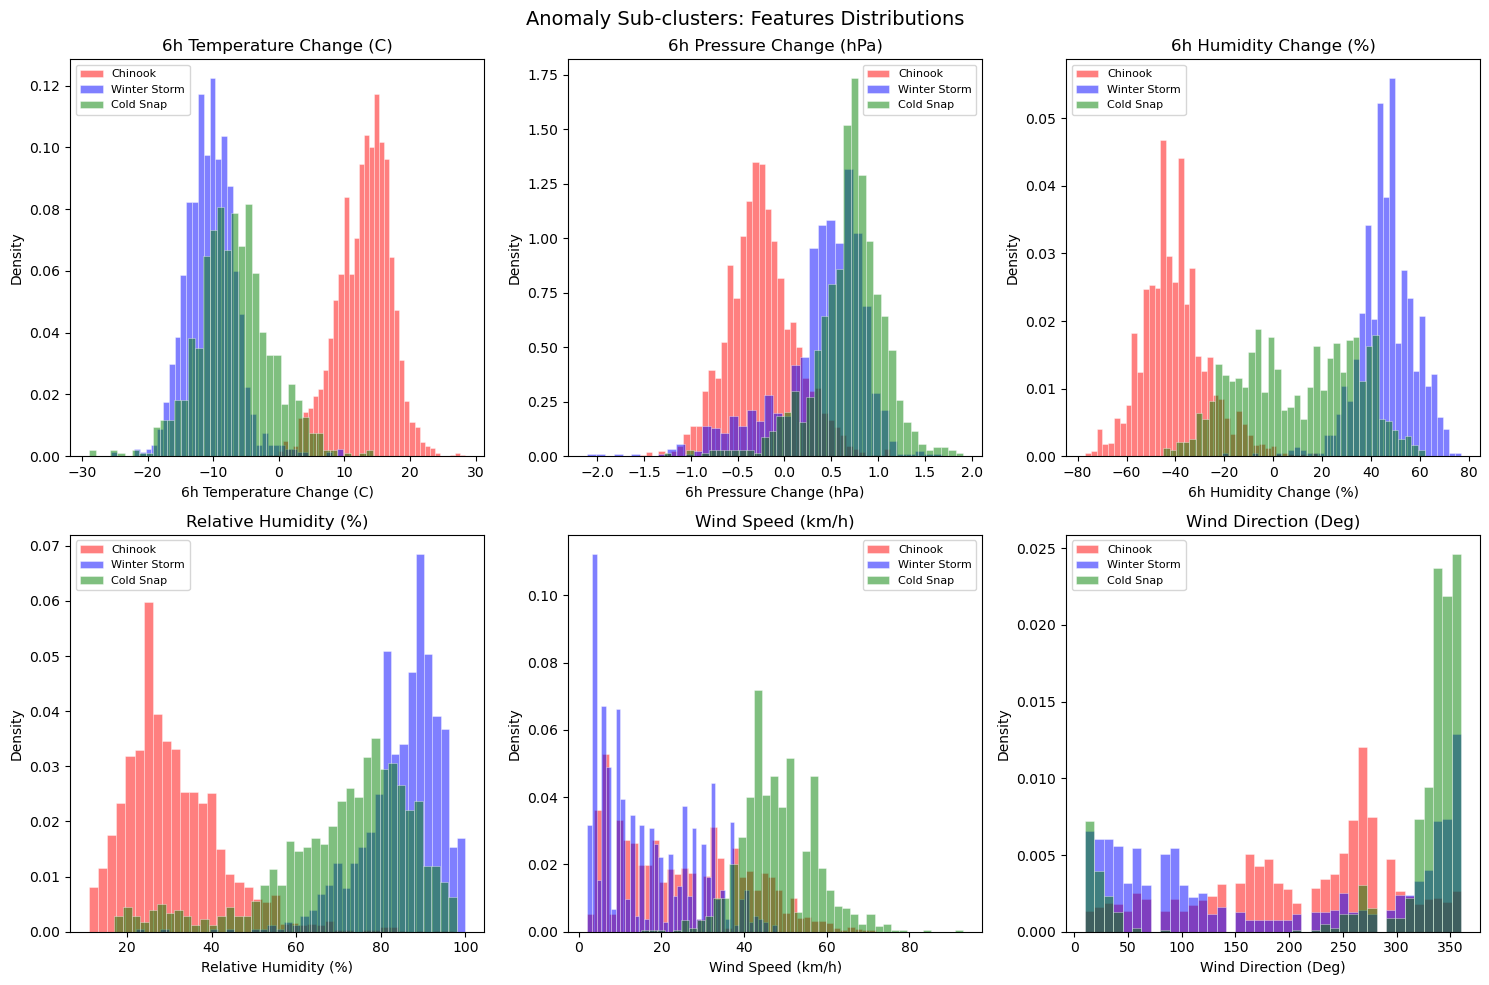

In [29]:
# Figure 1: Sub-cluster Comparison Graphs
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Features to compare
plot_features = ['temp_delta_6h', 'pressure_delta_6h', 'humidity_delta_6h', 
                 'rel_hum', 'wind_spd', 'wind_dir_deg']
plot_titles = ['6h Temperature Change (C)', '6h Pressure Change (hPa)', 
               '6h Humidity Change (%)', 'Relative Humidity (%)', 
               'Wind Speed (km/h)', 'Wind Direction (Deg)']

# Styling + labels
colors = {0: 'red', 1: 'blue', 2: 'green'} 
labels = {0: 'Chinook', 1: 'Winter Storm', 2: 'Cold Snap'}

axes = axes.ravel()

for ax, feat, title in zip(axes, plot_features, plot_titles):
    for cluster_id in range(N_SUBCLUSTERS):
        cluster_data = anomalies.loc[anomalies['subcluster'] == cluster_id, feat]

        ax.hist(
            cluster_data,
            bins=40,
            density=True,
            alpha=0.5,
            color=colors.get(cluster_id, 'gray'),
            edgecolor='white',
            linewidth=0.5,
            label=labels.get(cluster_id, f'Sub-cluster {cluster_id}')
        )

    ax.set_xlabel(title)
    ax.set_ylabel('Density')
    ax.set_title(title)
    ax.legend(fontsize=8)

fig.suptitle('Anomaly Sub-clusters: Features Distributions', fontsize=14)
fig.tight_layout()

Plotting the clusting - I wanted to see if I could pick out the trend graphically too.

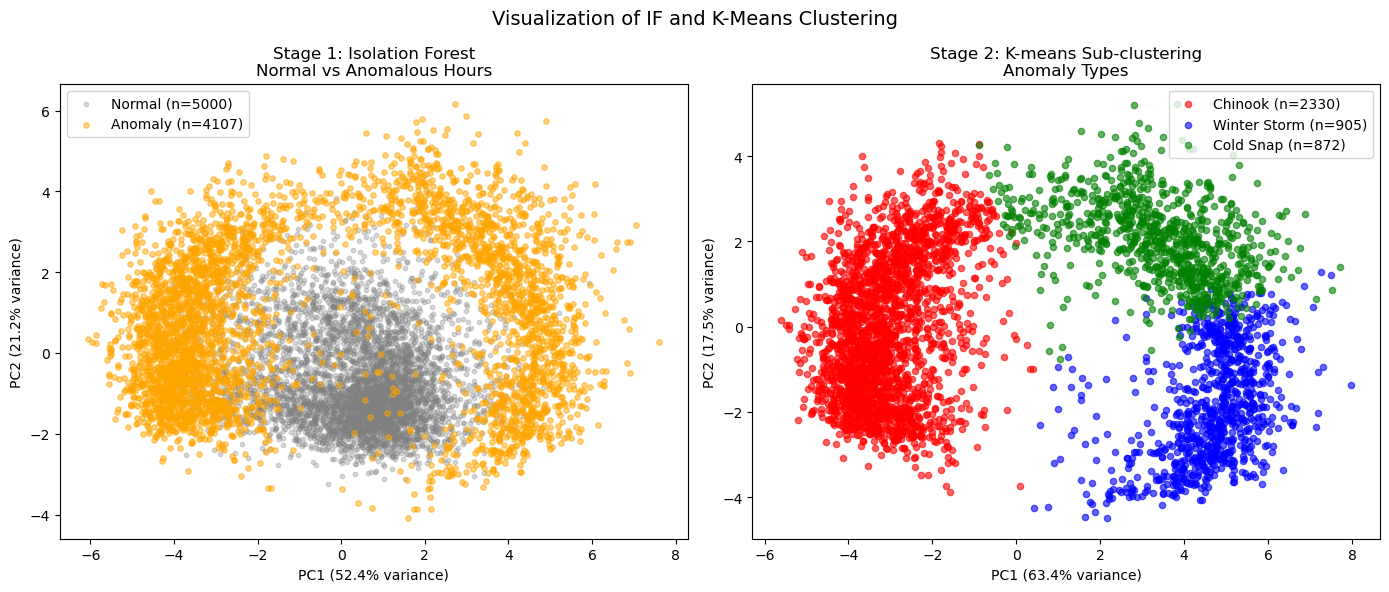

In [30]:
# Figure 2: Visualization of IF and K-Means Clustering
fig2, (ax_if, ax_km) = plt.subplots(1, 2, figsize=(14, 6))

# Sample normal data (to keep the plot readable)
n_sample = min(5000, len(normal))
normal_sample = normal.sample(n=n_sample, random_state=42)

# Build dataset for PCA: sampled normal + all anomalies
viz_data = pd.concat(
    [normal_sample[features_to_scale], anomalies[features_to_scale]],
    axis=0
)

# Use the same scaler as for the Isolation Forest
viz_scaled = scaler.transform(viz_data)

pca_if = PCA(n_components=2)
viz_pca = pca_if.fit_transform(viz_scaled)

n_norm = len(normal_sample)
n_anom = len(anomalies)

ax_if.scatter(
    viz_pca[:n_norm, 0], viz_pca[:n_norm, 1],
    c="gray", s=10, alpha=0.3,
    label=f"Normal (n={n_norm})"
)
ax_if.scatter(
    viz_pca[n_norm:, 0], viz_pca[n_norm:, 1],
    c="orange", s=15, alpha=0.5,
    label=f"Anomaly (n={n_anom})"
)

ax_if.set_xlabel(f"PC1 ({pca_if.explained_variance_ratio_[0]*100:.1f}% variance)")
ax_if.set_ylabel(f"PC2 ({pca_if.explained_variance_ratio_[1]*100:.1f}% variance)")
ax_if.set_title("Stage 1: Isolation Forest\nNormal vs Anomalous Hours")
ax_if.legend()

# Right panel: K-means sub-clusters within anomalies

# PCA on anomalies only (again using the same scaler)
anom_scaled = scaler.transform(anomalies[features_to_scale])
pca_km = PCA(n_components=2)
anom_pca = pca_km.fit_transform(anom_scaled)

# Loop over the subclusters
for cid in sorted(anomalies["subcluster"].unique()):
    mask = (anomalies["subcluster"] == cid)
    n_pts = int(mask.sum())
    if n_pts == 0:
        continue

    ax_km.scatter(
        anom_pca[mask.values, 0], anom_pca[mask.values, 1],
        c=colors.get(cid, "gray"),
        s=20, alpha=0.6,
        label=f"{labels.get(cid, f'Sub-cluster {cid}')} (n={n_pts})"
    )

ax_km.set_xlabel(f"PC1 ({pca_km.explained_variance_ratio_[0]*100:.1f}% variance)")
ax_km.set_ylabel(f"PC2 ({pca_km.explained_variance_ratio_[1]*100:.1f}% variance)")
ax_km.set_title("Stage 2: K-means Sub-clustering\nAnomaly Types")
ax_km.legend()

fig2.suptitle("Visualization of IF and K-Means Clustering", fontsize=14)
fig2.tight_layout()

I really liked the way this graphic turned out. You can see the anomalies and the different k-mean clusters clearly. The chinooks are in clear opposition to the winter storms/cold snaps. This makes me think again that temp is probably quite important to PC1. Going to do an importance test

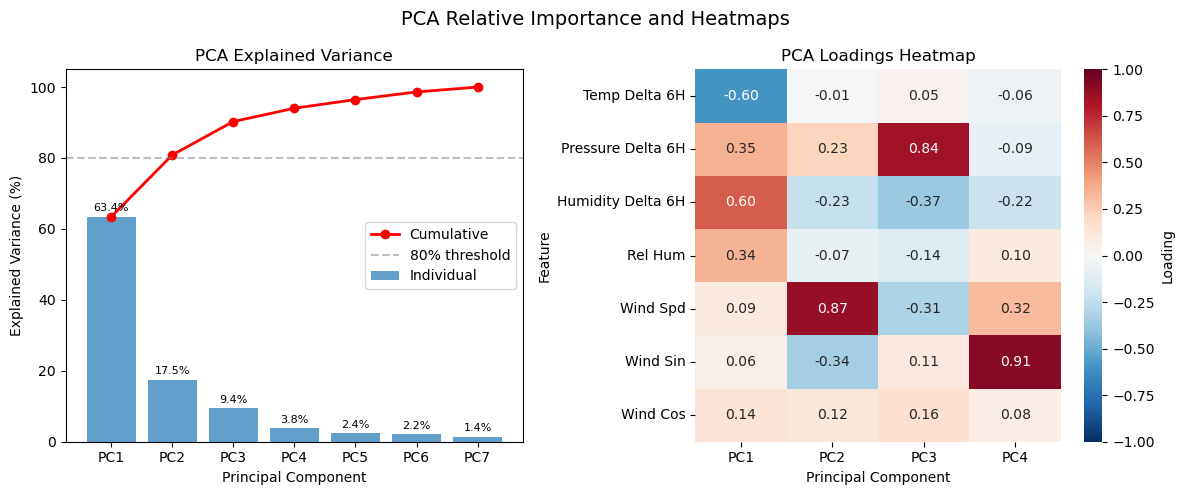

In [31]:
# Fit PCA on *scaled anomalies* using all components
X_anom_scaled = scaler.transform(anomalies[features_to_scale])

pca_full = PCA(n_components=len(features_to_scale))
pca_full.fit(X_anom_scaled)

# Making a cumulative var curve, like in Module 5
explained_var = pca_full.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Create loadings dataframe for the heatmap
loadings_df = pd.DataFrame(
    pca_full.components_.T,
    columns=[f"PC{i+1}" for i in range(len(explained_var))],
    index=[f.replace("_", " ").title() for f in features_to_scale],
)

# Graphing outcomes of PCA
# Figure 3: PCA Importance and Heatmaps

fig3, (ax_var, ax_heat) = plt.subplots(1, 2, figsize=(12, 5))

x_pcs = np.arange(1, len(explained_var) + 1)

bars = ax_var.bar(
    x_pcs,
    explained_var * 100,
    alpha=0.7,
    label="Individual"
)

ax_var.plot(
    x_pcs,
    cumulative_var * 100,
    "ro-",
    linewidth=2,
    markersize=6,
    label="Cumulative"
)

# Add percentage labels on bars
for bar, pct in zip(bars, explained_var):
    ax_var.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        f"{pct * 100:.1f}%",
        ha="center",
        va="bottom",
        fontsize=8,
    )

ax_var.axhline(80, color="gray", linestyle="--", alpha=0.5, label="80% threshold")
ax_var.set_xlabel("Principal Component")
ax_var.set_ylabel("Explained Variance (%)")
ax_var.set_title("PCA Explained Variance")
ax_var.set_xticks(x_pcs)
ax_var.set_xticklabels([f"PC{i}" for i in x_pcs])
ax_var.set_ylim(0, 105)
ax_var.legend(loc="best")

# Graphing loadings heatmap

# Showing just the first 4 PCs
n_pcs_to_show = min(4, loadings_df.shape[1])
loadings_to_plot = loadings_df.iloc[:, :n_pcs_to_show]

sns.heatmap(loadings_to_plot, annot=True, fmt=".2f", cmap="RdBu_r", center=0, vmin=-1, vmax=1, cbar_kws={"label": "Loading"}, ax=ax_heat)

ax_heat.set_title("PCA Loadings Heatmap")
ax_heat.set_xlabel("Principal Component")
ax_heat.set_ylabel("Feature")

fig3.suptitle("PCA Relative Importance and Heatmaps", fontsize=14)
fig3.tight_layout()


This confirms my hypothesis, that temperature and humidity (specifically one increasing while the other decreases) are the strongest drivers! This is followed by wind speed, then prssure change, followed by northerly-ness of the wind. Interesting westerly-ness didn't have much of an impact. I'm surprised pressure delta was relatively unimportant, but it seems to be somewhat captured in PC1 and PC2 as well. Very interesting.

Wrapping up this section with a comparison between chinooks and non-anomaly hours, using the code for the tables from above.

In [32]:
# Making a table, like above, but this time comparing non-anomaly hours to just the chinook anomaly hours (cluster == 1)
print(f"Comparing Chinooks vs Normal Conditions:")
print(f"{'Feature':<25} {'Normal':>12} {'Anomaly':>12} {'Difference':>12}")
chinook = anomalies[anomalies['subcluster'] == 0]
for feat in comparison_features:
    norm_mean = normal[feat].mean()
    chinook_mean = chinook[feat].mean()
    diff = chinook_mean - norm_mean
    print(f"{feat:<25} {norm_mean:>+12.2f} {chinook_mean:>+12.2f} {diff:>+12.2f}")

chinook_wind_dir = circular_mean(chinook['wind_dir_deg'])
norm_wind_dir = circular_mean(normal['wind_dir_deg'])
print(f"{'wind_dir':<25} {norm_wind_dir:>12.1f}deg {chinook_wind_dir:>12.1f}deg")

Comparing Chinooks vs Normal Conditions:
Feature                         Normal      Anomaly   Difference
temp_delta_6h                    -0.09       +12.99       +13.07
pressure_delta_6h                -0.00        -0.25        -0.25
humidity_delta_6h                +0.21       -40.18       -40.40
rel_hum                         +62.62       +30.97       -31.65
wind_spd                        +15.03       +24.95        +9.92
wind_dir                         248.7deg        243.7deg


Making a count of chinook DAYS rather than just chinook HOURS

In [33]:
# Mark Chinook hours (only the identified sub-cluster == 1)
df_winter['is_chinook'] = False
df_winter['subcluster'] = -1
chinook_indices = anomalies.index
df_winter.loc[chinook_indices, 'subcluster'] = anomalies['subcluster'].values
df_winter.loc[(df_winter['anomaly'] == -1) & (df_winter['subcluster'] == 0), 'is_chinook'] = True

chinook_hours = df_winter[df_winter['is_chinook']].copy()
chinook_hours['wind_dir_deg'] = chinook_hours['wind_dir'] * 10

# Add time components
df_winter['year'] = df_winter.index.year
df_winter['date'] = df_winter.index.date

# Count chinook hours per day
chinook_hours_per_day = df_winter.groupby('date')['is_chinook'].sum()
print(f"Total chinook hours = {chinook_hours_per_day.sum()}")

# A chinook day needs at least CHINOOK_MIN_HOURS_PER_DAY hours to count
chinook_days = chinook_hours_per_day[chinook_hours_per_day >= CHINOOK_MIN_HOURS_PER_DAY]
print(f"Total chinook days = {len(chinook_days):,}")

# Create date index for chinook days
chinook_days_df = pd.DataFrame({
    'date': chinook_days.index,
    'chinook_hours': chinook_days.values
})
chinook_days_df['date'] = pd.to_datetime(chinook_days_df['date'])
chinook_days_df['year'] = chinook_days_df['date'].dt.year
chinook_days_df['month'] = chinook_days_df['date'].dt.month

# Annual counts (Chinook days per year). Note: Using "winter year" Oct 2020 - Mar 2021 = winter 2020-21
chinook_days_per_year = chinook_days_df.groupby('year').size()
# Quick check, same length as above
#print(chinook_days_per_year.sum())
# Also count total chinook hours per year for comparison

chinook_hours_per_year = df_winter[df_winter['is_chinook']].groupby('year').size()
# Quick check, same length as above
#print(chinook_hours_per_year.sum())
print(f"Average number of cinook days per year = {chinook_days_per_year.sum()/50}")

Total chinook hours = 2330
Total chinook days = 343
Average number of cinook days per year = 6.86


### Part 4 Trend Analysis

Testing whether chinooks have actually become more common

In [34]:
# Making the x and y values (year and count respectively)
years = chinook_days_per_year.index.values
counts = chinook_days_per_year.values

slope, intercept, r_value, p_value, std_err = stats.linregress(years, counts)

print("Linear Regression - Chinook Days/Year")
print(f"Slope: {slope} days/year")
print(f"Std Error: {std_err}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")

Linear Regression - Chinook Days/Year
Slope: -0.03601809954751131 days/year
Std Error: 0.029644417732152244
R-squared: 0.029246155077021548
P-value: 0.23018673742585852


The linear regression shows a slightly decreasing trend, but not one that's statistically significant (p>0.05). 

In [35]:
tau, p = kendalltau(years, counts)

print("Mann-Kendall test - Chinook Days/Year")
print(f"Kendall's tau: {tau}")
print(f"P-value: {p}")

Mann-Kendall test - Chinook Days/Year
Kendall's tau: -0.12805396073024156
P-value: 0.20196376138700156


Same with the Mann-Kendall. A slightly decreasing trend, but not one that's statisticall significant.

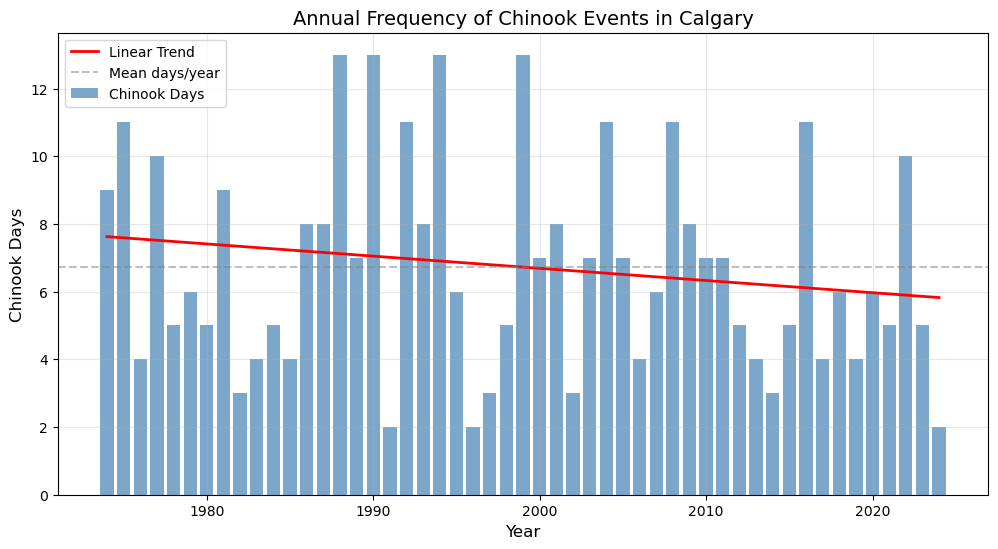

In [36]:
# Figure 4: Annual Chinook Days with Trend
fig4, ax4 = plt.subplots(figsize=(12, 6))
ax4.bar(years, counts, alpha=0.7, color='steelblue', label='Chinook Days')
ax4.plot(years, intercept + slope * years, 'r-', linewidth=2, 
         label=f'Linear Trend')
ax4.axhline(y=counts.mean(), color='gray', linestyle='--', alpha=0.5, 
            label='Mean days/year')
ax4.set_xlabel('Year', fontsize=12)
ax4.set_ylabel('Chinook Days', fontsize=12)
ax4.set_title('Annual Frequency of Chinook Events in Calgary', fontsize=14)
ax4.legend(loc='upper left')
ax4.grid(True, alpha=0.3)

Doing a check of my last hypothesis, that chinooks occur more often in shoulder months.Doing a chi-square test to test whether the count is uniformly distributed across months

In [37]:
# Monthly distribution of Chinook days (within winter season)
monthly_chinook = chinook_days_df.groupby('month').size()

# Hypothesis: More chinooks in shoulder months (Oct-Nov, Feb-Mar), less in Dec-Jan
shoulder_months = [2, 3, 10, 11] 
mid_winter_months = [12, 1]    

shoulder_count = monthly_chinook[monthly_chinook.index.isin(shoulder_months)].sum()
mid_winter_count = monthly_chinook[monthly_chinook.index.isin(mid_winter_months)].sum()
total_chinook = monthly_chinook.sum()

expected_per_month = total_chinook / len(CHINOOK_MONTHS)
observed = [monthly_chinook.get(m, 0) for m in CHINOOK_MONTHS]
chi2, chi2_p = stats.chisquare(observed)

print(f"Chi-square test to test for non-uniform distribution of chinooks across months:")
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {chi2_p}")

Chi-square test to test for non-uniform distribution of chinooks across months:
Chi-square statistic: 137.96209912536443
P-value: 4.850409386193768e-28


P << 0.05, so we can say that chinooks are unevenly distributed across months (this can be seen very clearly on the graph below too)

Text(0.5, 1.0, 'Monthly Distribution of Chinook Events (Winter Months Only)')

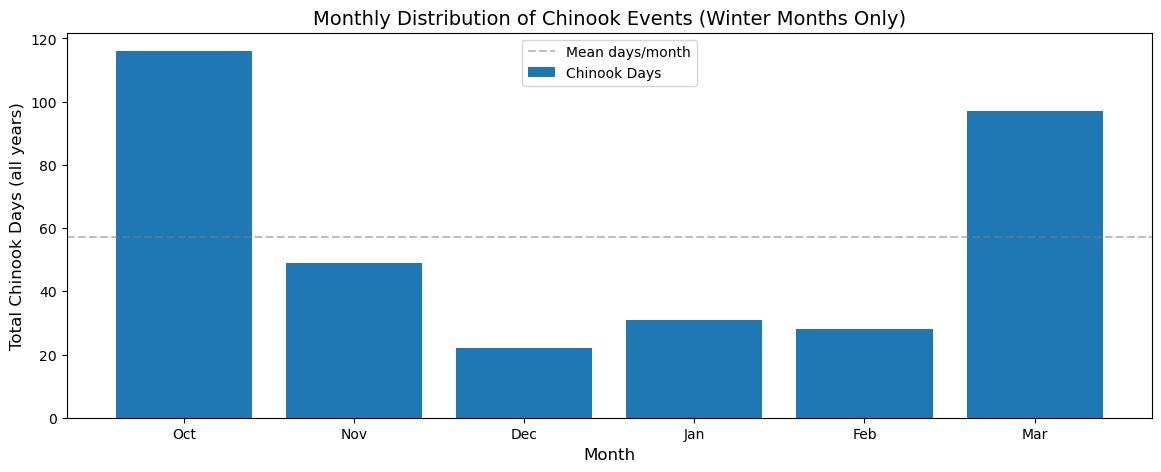

In [38]:
# Figure 5: Seasonal Distribution
fig5, ax5 = plt.subplots(figsize=(14, 5))

# Monthly bar chart (only winter months)
winter_month_names = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar']
winter_month_nums = [10, 11, 12, 1, 2, 3]
monthly_values = [monthly_chinook.get(m, 0) for m in winter_month_nums]

ax5.bar(winter_month_names, monthly_values, label='Chinook Days')
ax5.axhline(y=expected_per_month, color='gray', linestyle='--', alpha=0.5, 
            label='Mean days/month')
ax5.set_xlabel('Month', fontsize=12)
ax5.set_ylabel('Total Chinook Days (all years)', fontsize=12)
ax5.legend(loc='upper center')
ax5.set_title('Monthly Distribution of Chinook Events (Winter Months Only)', fontsize=14)